In [1]:
from google.colab import files
uploaded = files.upload()

Saving trans_data.py to trans_data.py


In [2]:
import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn import preprocessing
import lightgbm as lgb
from scipy.stats import spearmanr
from sklearn import metrics
from time import perf_counter

Učitavanje podataka iz datoteke trans_data.py:

In [3]:
! wget https://s3-us-west-2.amazonaws.com/xgboost-examples/MQ2008.rar
! unrar x MQ2008.rar
! mv -f MQ2008/Fold1/*.txt .
# convert data format
! python trans_data.py train.txt mq2008.train mq2008.train.group
! python trans_data.py test.txt mq2008.test mq2008.test.group
! python trans_data.py vali.txt mq2008.vali mq2008.vali.group

--2020-09-06 18:55:49--  https://s3-us-west-2.amazonaws.com/xgboost-examples/MQ2008.rar
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.176.232
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.176.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15448795 (15M) [application/x-rar-compressed]
Saving to: ‘MQ2008.rar’

MQ2008.rar          100%[===================>]  14.73M  15.1MB/s    in 1.0s    

2020-09-06 18:55:51 (15.1 MB/s) - ‘MQ2008.rar’ saved [15448795/15448795]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from MQ2008.rar

Creating    MQ2008                                                    OK
Creating    MQ2008/Fold1                                              OK
Extracting  MQ2008/Fold1/test.txt                                          0%  1%  2%  OK 
Extracting  MQ2008/Fold1/train.txt                                         2%  3%

In [4]:
x_train, y_train = load_svmlight_file("mq2008.train")
x_valid, y_valid = load_svmlight_file("mq2008.vali")
x_test, y_test = load_svmlight_file("mq2008.test")

In [5]:
q_train = np.loadtxt('mq2008.train.group')
q_valid = np.loadtxt('mq2008.vali.group')
q_test = np.loadtxt('mq2008.test.group')



> **Kreiranje i treniranje modela**


Koristićemo funkciju LGBMRanker() biblioteke lightgbm za kreiranje "rankera". 
GBM u nazivu dolazi od engleskog Gradient Boosting Machine. LightGBM je frejmvork koji koristi algoritme učenja bazirane na drvima.
Tokom treniranja ispisuje se rezultat svake instance.

In [6]:
gbm = lgb.LGBMRanker()
start_training = perf_counter()
gbm.fit(x_train, y_train, group=q_train, eval_set=[(x_valid, y_valid)],
eval_group=[q_valid], eval_at=[1, 3], early_stopping_rounds=20, verbose=True,
callbacks=[lgb.reset_parameter(learning_rate=lambda x: 0.95 ** x * 0.1)])
end_training = perf_counter()

[1]	valid_0's ndcg@1: 0.556263	valid_0's ndcg@3: 0.635254
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's ndcg@1: 0.571125	valid_0's ndcg@3: 0.66308
[3]	valid_0's ndcg@1: 0.617834	valid_0's ndcg@3: 0.675826
[4]	valid_0's ndcg@1: 0.622081	valid_0's ndcg@3: 0.682879
[5]	valid_0's ndcg@1: 0.632696	valid_0's ndcg@3: 0.6769
[6]	valid_0's ndcg@1: 0.624204	valid_0's ndcg@3: 0.677868
[7]	valid_0's ndcg@1: 0.613588	valid_0's ndcg@3: 0.671651
[8]	valid_0's ndcg@1: 0.613588	valid_0's ndcg@3: 0.670299
[9]	valid_0's ndcg@1: 0.626327	valid_0's ndcg@3: 0.675637
[10]	valid_0's ndcg@1: 0.62845	valid_0's ndcg@3: 0.680989
[11]	valid_0's ndcg@1: 0.62845	valid_0's ndcg@3: 0.679431
[12]	valid_0's ndcg@1: 0.626327	valid_0's ndcg@3: 0.684499
[13]	valid_0's ndcg@1: 0.641189	valid_0's ndcg@3: 0.688833
[14]	valid_0's ndcg@1: 0.619958	valid_0's ndcg@3: 0.688054
[15]	valid_0's ndcg@1: 0.619958	valid_0's ndcg@3: 0.686626
[16]	valid_0's ndcg@1: 0.626327	valid_0's ndcg@3: 0.691959
[17]	val

In [9]:
print('Vreme treniranja u sekundama: ', end_training - start_training)

Vreme treniranja u sekundama:  0.5195624019999627


Ako je trening uspešan trebalo bi da uočimo korelaciju između rezultata relevantnosti svake instance u trening skupu i predviđenog rezultata.

In [10]:
y_predicted_train = gbm.predict(x_train)
spearmanr(y_train, y_predicted_train)

SpearmanrResult(correlation=0.41298395158905504, pvalue=0.0)

Sve instance možemo staviti u istu grupu. Na ovaj način lightGBM poredi svaku instancu sa svakom.
Kako sada imamo više parova za poređenje trening će biti nešto sporiji ali ukupna korelacija između predviđenog rezultata i relevantnh rezultata bi trebalo da se poveća.

In [11]:

q_train2 = [x_train.shape[0]]
q_valid2 = [x_valid.shape[0]]
q_test2 = [x_test.shape[0]]

gbm2 = lgb.LGBMRanker()
start_training2 = perf_counter()
gbm2.fit(x_train, y_train, group=q_train2, eval_set=[(x_valid, y_valid)],
eval_group=[q_valid2], eval_at=[1, 3], early_stopping_rounds=20, verbose=True,
callbacks=[lgb.reset_parameter(learning_rate=lambda x: 0.95 ** x * 0.1)])
end_training2 = perf_counter()

[1]	valid_0's ndcg@1: 0	valid_0's ndcg@3: 0
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's ndcg@1: 0	valid_0's ndcg@3: 0
[3]	valid_0's ndcg@1: 0	valid_0's ndcg@3: 0
[4]	valid_0's ndcg@1: 0	valid_0's ndcg@3: 0.0782131
[5]	valid_0's ndcg@1: 0	valid_0's ndcg@3: 0.176907
[6]	valid_0's ndcg@1: 0	valid_0's ndcg@3: 0.176907
[7]	valid_0's ndcg@1: 0	valid_0's ndcg@3: 0.176907
[8]	valid_0's ndcg@1: 0	valid_0's ndcg@3: 0.176907
[9]	valid_0's ndcg@1: 0	valid_0's ndcg@3: 0.176907
[10]	valid_0's ndcg@1: 0.333333	valid_0's ndcg@3: 0.48976
[11]	valid_0's ndcg@1: 0.333333	valid_0's ndcg@3: 0.687148
[12]	valid_0's ndcg@1: 0.333333	valid_0's ndcg@3: 0.530721
[13]	valid_0's ndcg@1: 0.333333	valid_0's ndcg@3: 0.530721
[14]	valid_0's ndcg@1: 0.333333	valid_0's ndcg@3: 0.530721
[15]	valid_0's ndcg@1: 0.333333	valid_0's ndcg@3: 0.452508
[16]	valid_0's ndcg@1: 0.333333	valid_0's ndcg@3: 0.391066
[17]	valid_0's ndcg@1: 0.333333	valid_0's ndcg@3: 0.391066
[18]	valid_0's ndcg@1: 0.333

In [12]:
print('Vreme treniranja u sekundama: ', end_training2 - start_training2)

Vreme treniranja u sekundama:  9.085943797000027


In [13]:
y_predicted2_train = gbm2.predict(x_train)
spearmanr(y_train, y_predicted2_train)

SpearmanrResult(correlation=0.4285660920886821, pvalue=0.0)

Možemo primetiti da se koreacija zaista jeste povećala, ali isto tako možemo primetiti da se vreme treniranja modela u velikoj meri povećalo.


> **Evaluacija modela:**


Koristićemo NDCG (normalized discountet cumulative gain) metriku, koja predstavlja normalizovanu vrednost DCG metrike.
DCG metrika nagrađuje stavljanje dobrih instanci na višu poziciju i alocira veću težinu za pravilno rangirane instance sa većim rankom.
Normalizovana DCG predstavlja DCG podeljenu maksimalnom vrednošću DCG (a to je DCG koja bi se dobila savršenim rangiranjem).

In [15]:
y_predicted = gbm.predict(x_test)
#y_test = np.asarray([y_test])
y_predicted = np.asarray([y_predicted])
ndcg = metrics.ndcg_score(y_test, y_predicted)

In [16]:
print('Vrednost NDCG metrike na prvom modelu: ', ndcg)

Vrednost NDCG metrike na prvom modelu:  0.8059293618324704


In [30]:
y_predicted2 = gbm2.predict(x_test)
#y_test = np.asarray([y_test])
y_predicted2 = np.asarray([y_predicted2])
ndcg = metrics.ndcg_score(y_test, y_predicted2)


In [31]:
print('Vrednost NDCG metrike na prvom modelu: ', ndcg)

Vrednost NDCG metrike na prvom modelu:  0.8123978788530549


Na sledećem grafiku biće prikazana važnost atributa. Atributi će biti obeleženi vrednostima "Column_num" gde je svaki atribut predstavljen svojim rednim brojem iz tabele kojom smo opisali postojeće atribute.

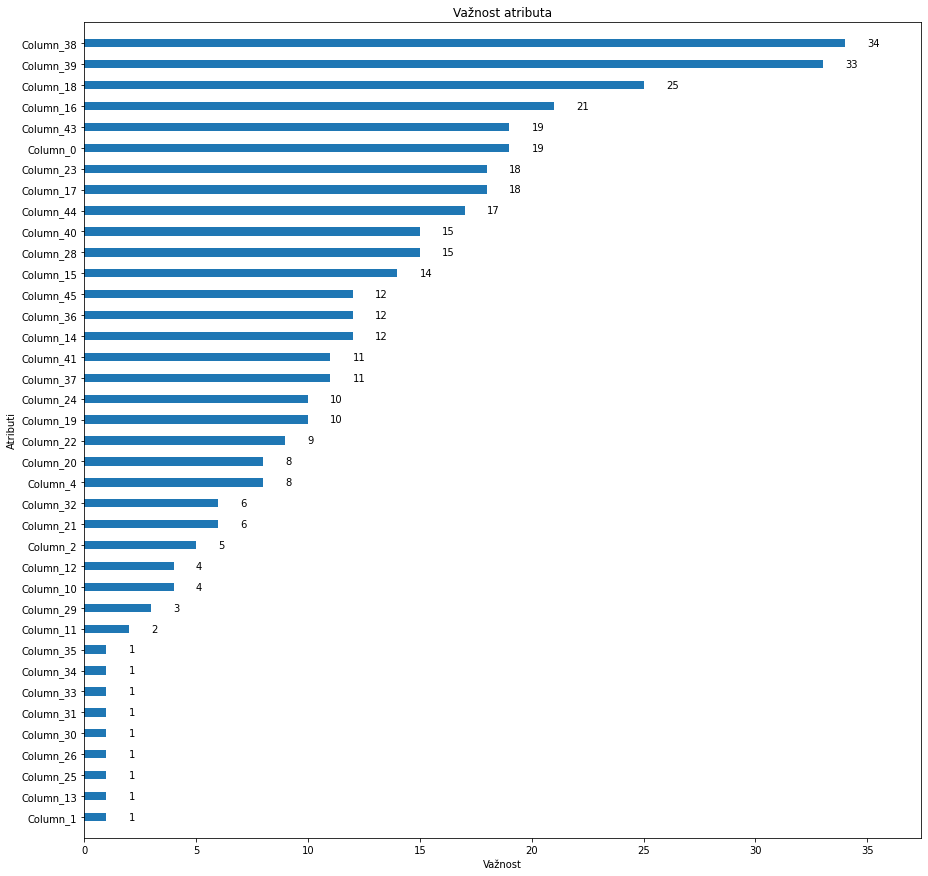

In [32]:
lgb.plot_importance(gbm, title = "Važnost atributa", xlabel="Važnost", ylabel="Atributi", figsize=(15,15), height = 0.4, grid = False)


Kada sve instance stavimo u istu grupu imamo nešto drugačije važnosti atributa.

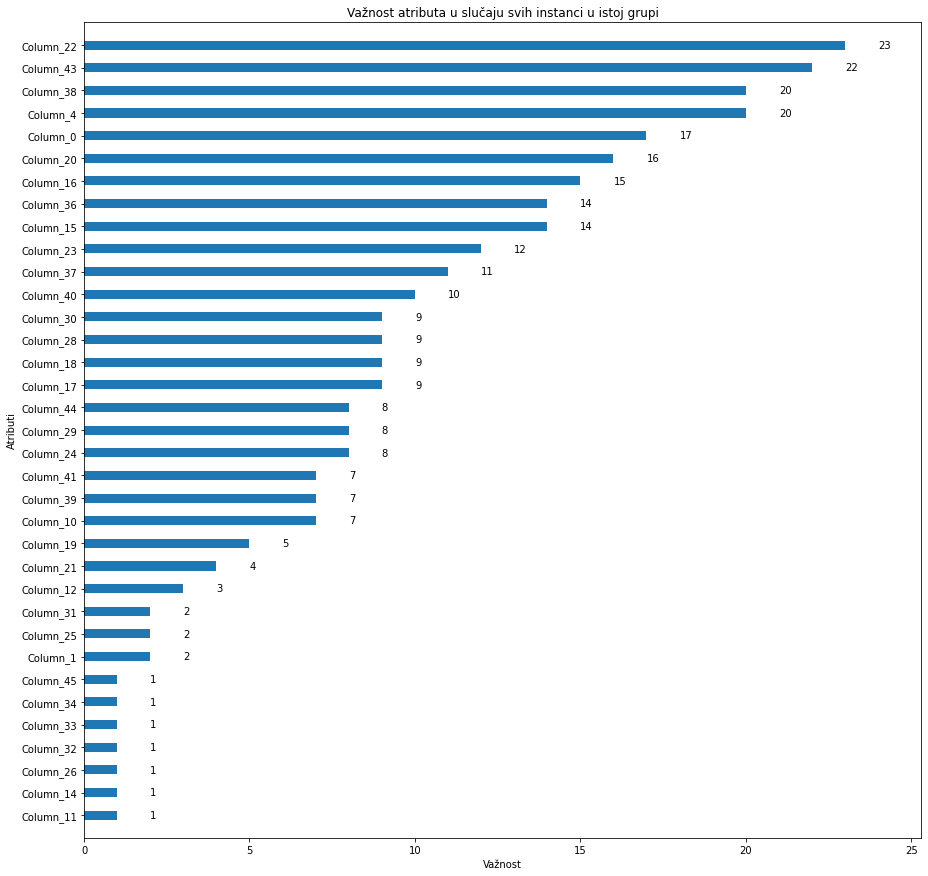

In [33]:
lgb.plot_importance(gbm2, title = "Važnost atributa u slučaju svih instanci u istoj grupi", xlabel="Važnost", ylabel="Atributi", figsize=(15,15), height = 0.4, grid = False)


Prikažimo sada dijagram jednog drveta.

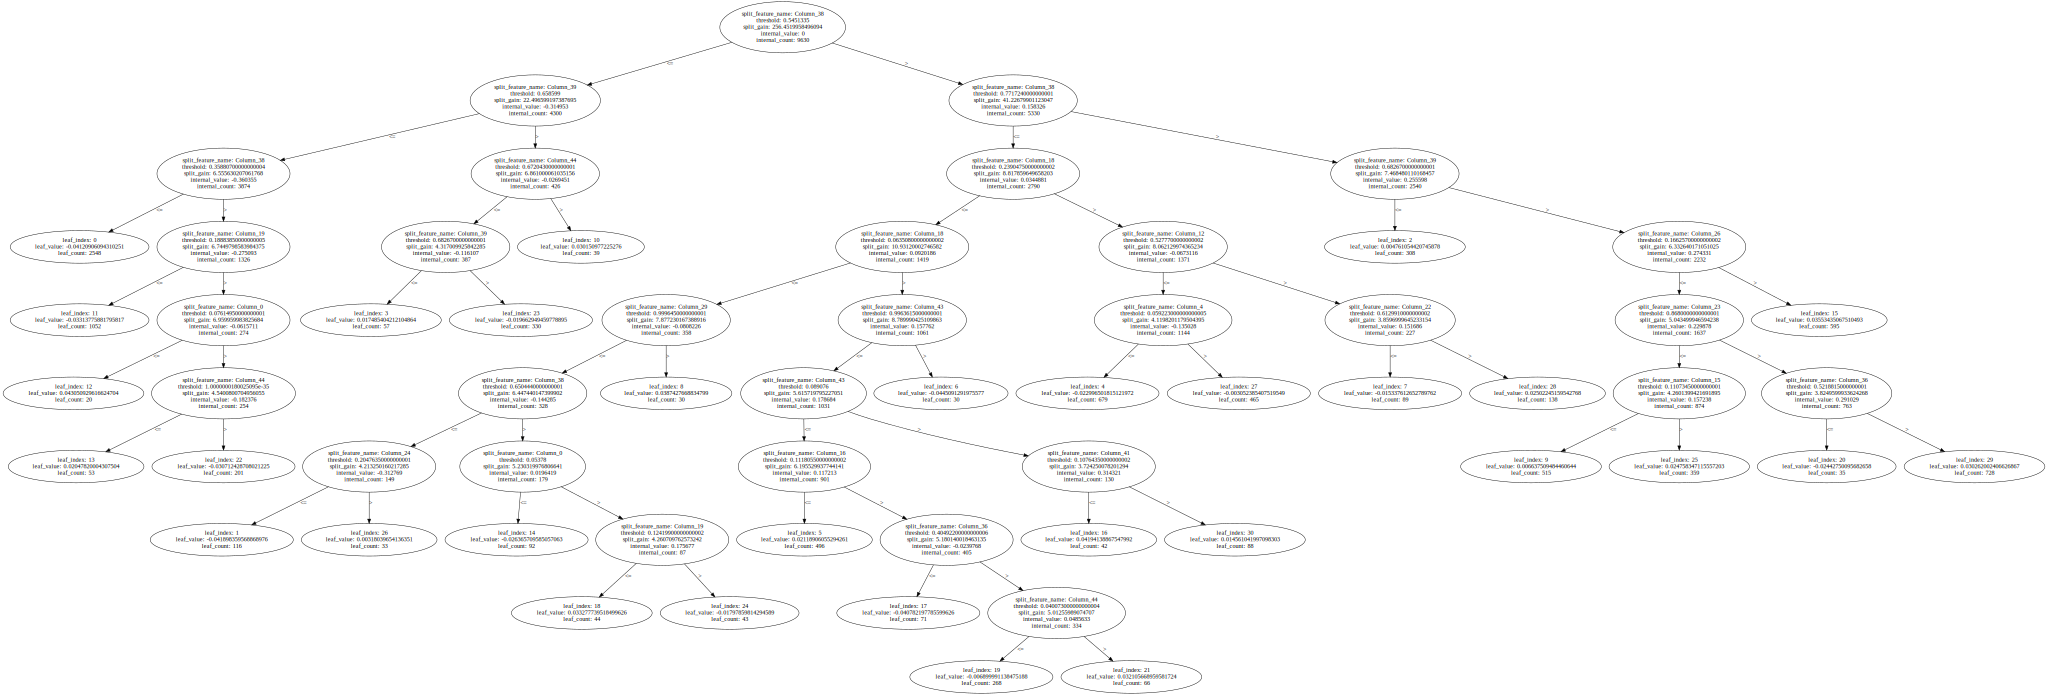

In [34]:
lgb.create_tree_digraph(gbm, show_info=('split_gain', 'internal_value', 'internal_count', 'internal_weight', 'leaf_count', 'leaf_weight', 'data_percentage'))

U modelu u kom su sve instance u istoj grupi situacija je drugačija.

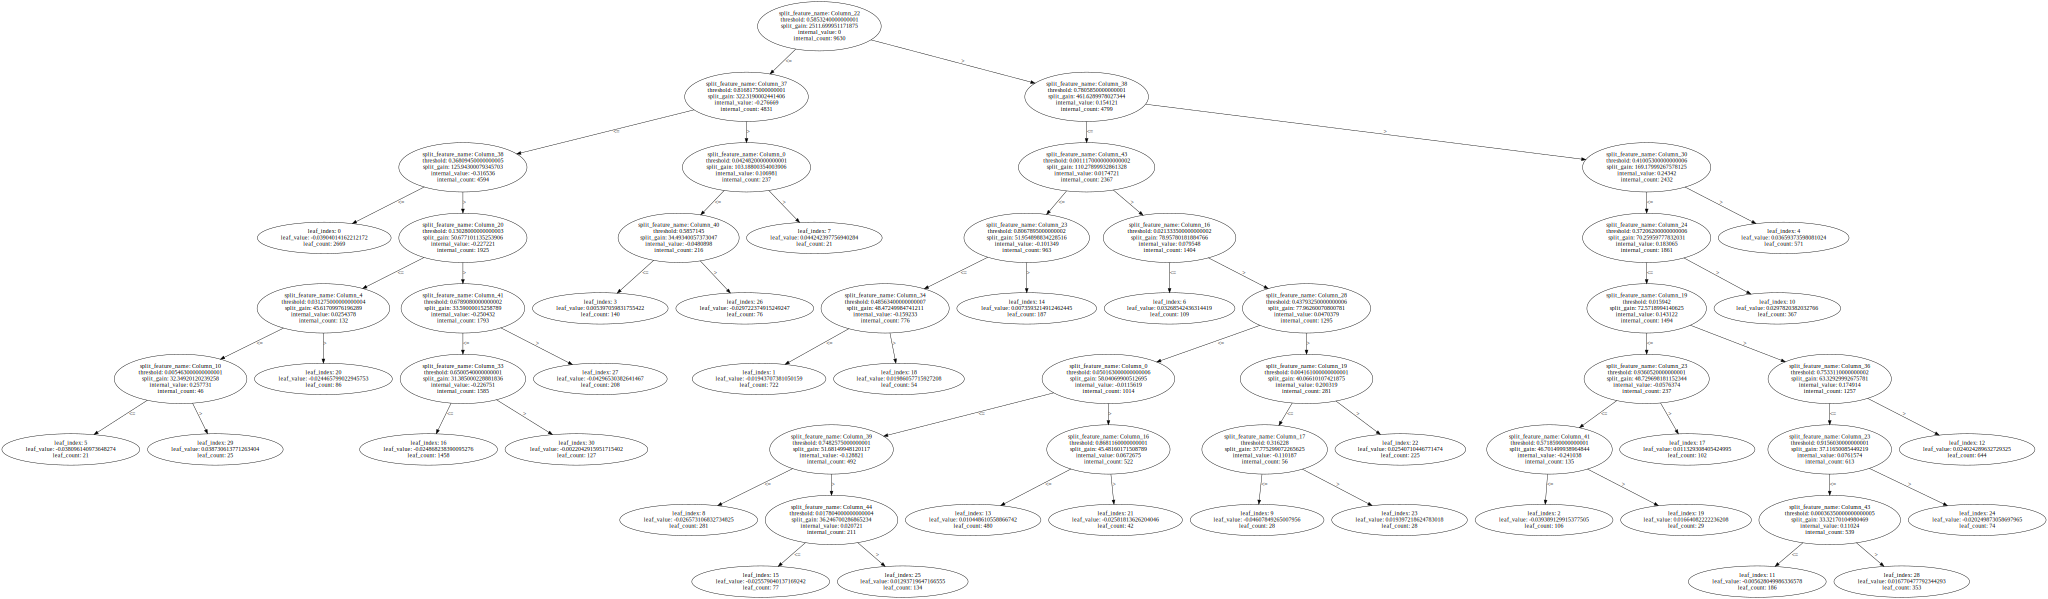

In [35]:
lgb.create_tree_digraph(gbm2, show_info=('split_gain', 'internal_value', 'internal_count', 'internal_weight', 'leaf_count', 'leaf_weight', 'data_percentage'))

Najbolja iteracija modela:

In [36]:
gbm.best_iteration_

13

In [37]:
gbm2.best_iteration_

10

Najbolji rezultat modela:

In [38]:
gbm.best_score_

defaultdict(dict,
            {'valid_0': {'ndcg@1': 0.6411889596602973,
              'ndcg@3': 0.6888330999565413}})

In [39]:
gbm2.best_score_

defaultdict(dict,
            {'valid_0': {'ndcg@1': 0.3333333333333333,
              'ndcg@3': 0.4897595753409189}})

In [40]:
gbm.objective_

'lambdarank'